In [1]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
from collections import defaultdict
import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Preprocessing
from analyzer import python_analyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from vectorizer import NCutVectorizer

# Learning
from clustering import Clustering

# Evaluation
from sklearn.metrics import silhouette_samples, silhouette_score

# Plots
import matplotlib.pyplot as plt

%matplotlib notebook

/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Data

In [2]:
topics = ["business", "entertainment", "politics", "sport", "tech"]
docs = []
base_path = "bbc"
for t in topics:
    docs_title = os.listdir("%s/%s" % (base_path,t))
    for item in docs_title:
        with open('%s/%s/%s' %(base_path, t, item), 'r') as txtfile:
            try:
                docs.append(txtfile.read())
            except UnicodeDecodeError:
                print("Error on doc %s/%s" % (t,item))

Error on doc sport/199.txt


In [3]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = 'word',
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T


### Preprocessing solutions into bag of words ###

In [4]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
#     vectorizer = vectorizer_method(analyzer = python_analyzer,
    vectorizer = vectorizer_method(analyzer = 'word',
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features

In [8]:
%%time
dataset = "bbc_5"
vectorizers = [CountVectorizer]
               #TfidfVectorizer, 
#                NCutVectorizer]
# min_df = np.arange(0.05, 0.5, 0.05)
min_df = [0.25]
binary = [True]
          #, False]
cluster_methods = ['nmf']
                   #'lda']
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = ['cosine']
          #, 'euclidean', 'cosine']

results = []
    
# Grid search
for v in vectorizers:
    for m in min_df:
        for b in binary:
            train_data_features = create_bag_of_words(docs, v, binary=b, min_df=m)
            print(train_data_features.shape)
            
            # Remove rows containing only zeros (weird exercises)
            solution_sample = train_data_features[~(train_data_features==0).all(1)]
            if solution_sample.shape != train_data_features.shape:
                error = {
                    "vectorizer": v,
                    "min_df": m,
                    "binary": b
                }
                print("ERROR: %s" % error)
            
#             clusters = range(2, int(np.sqrt(min(train_data_features.shape)))+1)
            clusters = range(2, 3)
            for k in tqdm_notebook(clusters):
                for dist in metric:
                    clustering = Clustering(train_data_features, k, metric=dist)
                    gap = Gap(train_data_features, k, nrefs=100, distance=dist)

                    for method in cluster_methods:
                        start = time.time()
                        model, document_topic, word_topic = getattr(clustering, method)()
                        clusters = document_topic.argmax(axis=1)

                        # Compute Gap
                        start = time.time()
                        k_gap = gap.calculate_gap(clustering, method)
                        end = time.time()
                        gap_time = end-start

                        # Compute silhouette. Keep single to values to be able to plot it later
                        start = time.time()
                        k_silhouette = silhouette_score(train_data_features, clusters, metric=dist)
                        # Compute the silhouette scores for each sample
                        sample_silhouette_values = silhouette_samples(train_data_features, clusters, metric=dist)
                        end = time.time()
                        silhouette_time = end-start
                        
                        # UMass coherence
                        start = time.time()
                        k_coherence = calculate_umass_coherence(train_data_features, word_topic, clusters, k)
                        end = time.time()
                        coherence_time = end-start

                        results.append({
                            "dataset": dataset,
                            "X": train_data_features,
                            "y": clusters,
                            "vectorizer": v.__name__,
                            "is_binary": b,
                            "min_df": m,
                            "distance": dist,
                            "k": k,
                            "method": method,
                            "model": model,
                            "gap": k_gap[0],
                            "gap_std": k_gap[1],
                            "gap_time": gap_time,
                            "silhouette": k_silhouette,
                            "silhouette_samples": sample_silhouette_values,
                            "silhouette_time": silhouette_time,
                            "coherence_samples": k_coherence[0],
                            "coherence_med": k_coherence[1],
                            "coherence_std": k_coherence[2],
                            "coherence_time": coherence_time,
                            "coherence_k": len(k_coherence[0])
                        })

(2224, 91)



CPU times: user 4min 7s, sys: 7.17 s, total: 4min 14s
Wall time: 2min 10s


In [10]:
df = pd.DataFrame(results)

In [11]:
qgrid.show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [89]:
# gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap'].values.tolist()
# error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'NCutVectorizer') & (df['binary'] == True)]['gap_error'].values.tolist()
gaps = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['gap_avg'].values.tolist()
error = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['gap_std'].values.tolist()
sils = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['silhouette'].values.tolist()
coherence = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['coherence_med'].values.tolist()
coherence_std = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['coherence_std'].values.tolist()
coherence_array = df[(df['method'] == 'nmf') & (df['vectorizer'] == 'CountVectorizer') & (df['binary'] == True)]['coherence'].values.tolist()

In [90]:
def define_k(gaps, error):
    for i in range(2,len(gaps)):
        k = i-2
        gapi = gaps[k]
        gapi1 = gaps[k+1]
        std = error[k+1]
        
        if gapi >= (gapi1-std):
            print("k = %d" % (k+2))
            break
            
    diff = np.array(gaps) - np.array(error)
    gaps[1:] = gaps[:-1]
    gap_diff = np.array(gaps) > diff
    k = np.argmax(gap_diff[1:] == True)
    print("k = %d" % (k+2))

<IPython.core.display.Javascript object>


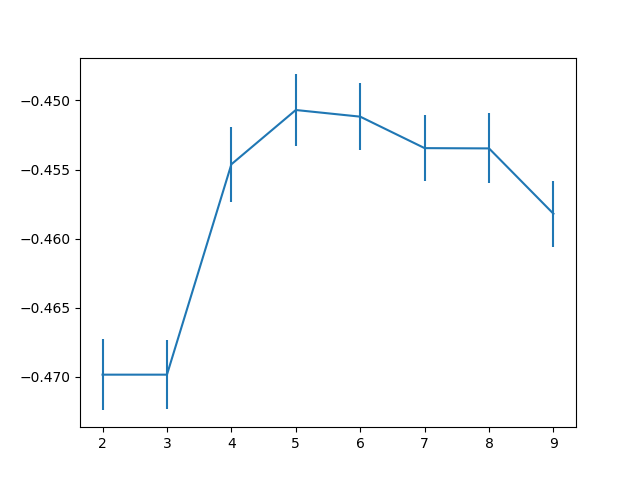

k = 2
k = 2


In [92]:
# Plot data
plt.figure()
plt.errorbar(range(2,len(gaps)+2), gaps, yerr=error)
plt.show()

# Get best k
k = define_k(gaps, error)

<IPython.core.display.Javascript object>


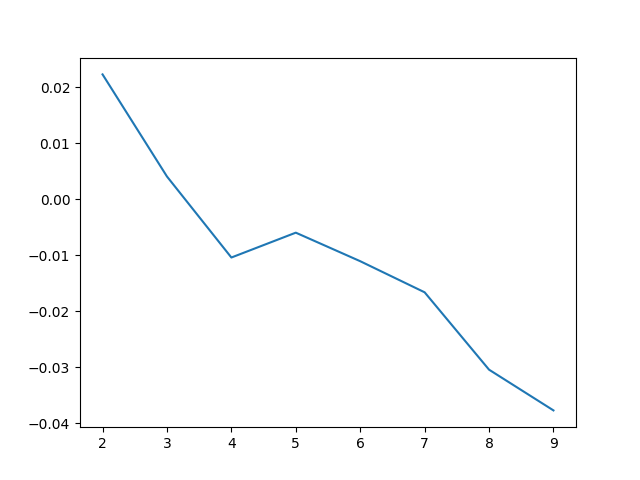

k = 2


In [93]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
k = np.argmax(np.asarray(sils))+2
print("k = %d" % k)

<IPython.core.display.Javascript object>


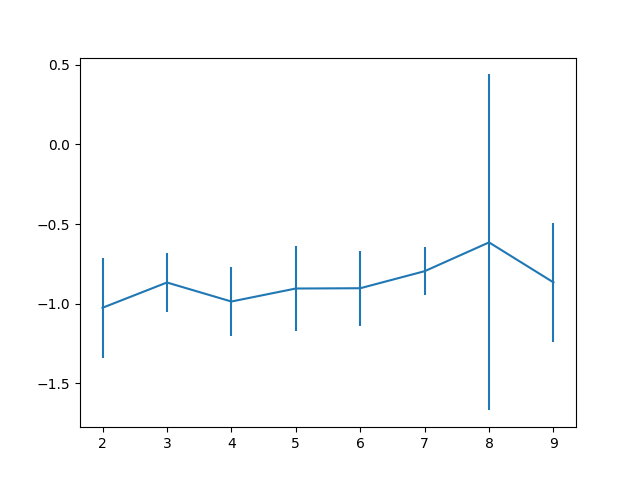

k = 8
CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 44.5 ms


In [94]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence)+2), coherence, yerr=coherence_std)
# plt.show()

# Get best k
k = np.argmax(np.asarray(coherence))+2
# k = get_curve_knee(range(1,len(coherence)+1), coherence)
print("k = %d" % k)

<IPython.core.display.Javascript object>


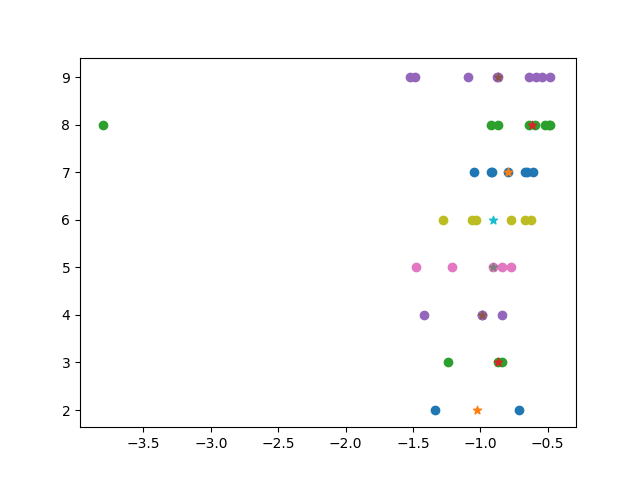

-1.0251487557049503
-0.8666579768780599
-0.9859990184984269
-0.9044445031909195
-0.9026286769983486
-0.7956948268740304
-0.6149084860086218
-0.865893913223452


In [95]:
plt.figure()
for idx, i in enumerate(coherence_array):
    median = np.median(i)
    print(median)
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")

In [12]:
import pickle

with open("clustering_bcc.pkl", "wb") as pklfile:
    pickle.dump(df, pklfile)

In [6]:
from scipy.spatial.distance import pdist
import scipy
import numpy as np

class Gap(object):
    def __init__(self, data, k, nrefs=20, distance='cosine'):
        self._prepare_ref_dataset(data, nrefs)
        self.k = k
        self.X = data
        self.distance = distance
        
    def _prepare_ref_dataset(self, data, nrefs=20):
        shape = data.shape
        # Set bounding box
        tops = data.max(axis=0)
        bots = data.min(axis=0)

        # Generate distribution
        self.refs = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))

        # Set offset for random uniform samples to be inside bounding boxes
        dists = scipy.matrix(scipy.diag(tops-bots))
        for i in range(nrefs):
            self.refs[:,:,i] = self.refs[:,:,i]*dists+bots

        return self.refs
    
    def calculate_wk(self, X, y):
        """ Calculate nr, dr and wk """
        min_k = np.array(y).min()
        max_k = np.array(y).max()
        wk = []

        for i in range(min_k, max_k+1):
            # Calculate Dr for each cluster
            obs_idx = np.where(y == i)[0]
            nr = obs_idx.shape[0]

    #         if nr == 0:
    #             raise TypeError("There are empty clusters.")

            # Get pairwise distance
            dist = pdist(X[obs_idx], self.distance).sum()

            # Calculate Wk
            wki = dist/(2*nr)
            wk.append(wki)

        return np.array(wk).sum()
    
    def calculate_ref_wk(self, method, k):
        self.wk_refs = []
        
        for ref in range(self.refs.shape[2]):
            ref_clustering = Clustering(self.refs[:,:,ref], k)
            model, document_topic, word_topic = getattr(ref_clustering, method)()
            clusters = ref_clustering.document_topic.argmax(axis=1)
            wk_ref = self.calculate_wk(self.refs[:,:,ref], clusters)
            log_wk_ref = np.log(wk_ref)
            self.wk_refs.append(log_wk_ref)
            
        return self.wk_refs
            
    def calculate_gap(self, clustering, method):
        # Calculate Wk for original data
        clusters = clustering.document_topic.argmax(axis=1)
        wk = self.calculate_wk(self.X, clusters)
        log_wk = np.log(wk)

        # Calculate Wk for reference distribution
        wk_refs = self.calculate_ref_wk(method, self.k)
        wkb = np.array(wk_refs)
        wkb_sum = wkb.sum()
        wkb_std = wkb.std()
        B = wkb.shape[0]

        # Calculate Gap
        gap_k = (1/B*wkb_sum) - log_wk
        error = wkb_std*np.sqrt(1+(1/B))

        return gap_k, error

In [7]:
from itertools import permutations

def calculate_umass_coherence(X, word_topic, clusters, k, N=5):
    k_coherence = []
    for idx_cluster in range(k):
        cluster_data = X[clusters == idx_cluster]
        
        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue
        
        # Calculate cooccurence matrix
        cluster_data[np.where(cluster_data > 1)] = 1
        cooccurence = np.dot(cluster_data.T, cluster_data)
        
        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        perms = permutations(idx, 2)
        k_score = []
        for i,j in perms:
            if cooccurence[i,i] == 0:
                continue
            score = np.log((cooccurence[i,j]+0.01)/cooccurence[i,i])
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_coherence.append(k_topic)
    return k_coherence, np.median(k_coherence), np.std(k_coherence)